## Libraries

In [ ]:
!pip install --upgrade pip
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -U scikit-learn
!pip install h5py
!pip install matplotlib

### Run: load libraries

In [1]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.optim as optim

import h5py
import glob
import os

## Data

### Run: data path

In [2]:
# Ubuntu data load
# path = '/home/sunzid/Research/23-24_Automatic-Control-Lab/Projects/24_Aerosol/data/'
# pace318_train = glob.glob(path + 'pace318_train_set/H5/*.h5')
# pace318_test = glob.glob(path + 'pace318_test_set/H5/*.h5')

# Windows data load
# Windows data load
path = r'c:\Users\sha040\Documents\24_aerosol'
pace318_train = glob.glob(os.path.join(path, 'pace318_train_set', 'H5', '*.h5'))
pace318_test = glob.glob(os.path.join(path, 'pace318_test_set', 'H5', '*.h5'))


### Data check

In [ ]:

rowNum = 3

if pace318_train:
    with h5py.File(pace318_train[0], 'r') as file:
        print("Keys: %s" % list(file.keys()))
        first_geometry = file['geometry'][rowNum]
        first_input = file['inputs'][rowNum]
        first_output = file['outputs'][rowNum]

        print('Pace 318\n')
        print("first_geometry shape: ", first_geometry.shape, 
              "first_geometry: ", first_geometry, '\n')
        print("first_input shape: ", first_input.shape,
              "first_input: ", first_input, '\n')
        print("first_output shape: ", first_output.shape,
              "first_output: ", first_output, '\n')
else:
    print("Pace 318 file not found")

pace325_train = glob.glob(os.path.join(path, 'pace325_train_set', 'H5', '*.h5'))
pace325_test = glob.glob(os.path.join(path, 'pace325_test_set', 'H5', '*.h5'))

if pace325_train:
    with h5py.File(pace325_train[0], 'r') as file:
        print("Keys: %s" % list(file.keys()))
        first_geometry = file['geometry'][rowNum]
        first_input = file['inputs'][rowNum]
        first_output = file['outputs'][rowNum]

        print('Pace 325\n')
        print("first_geometry shape: ", first_geometry.shape, 
              "first_geometry: ", first_geometry, '\n')
        print("first_input shape: ", first_input.shape,
              "first_input: ", first_input, '\n')
        print("first_output shape: ", first_output.shape,
              "first_output: ", first_output, '\n')
else:
    print("Pace 325 file not found")


### Train and test data

#### Run: input in

In [3]:
# Custom Dataset class
class H5_IO_Dataset(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths
    
    def __len__(self):
        # Assuming all files have the same number of rows for simplicity
        with h5py.File(self.file_paths[0], 'r') as file:
            return file['geometry'].shape[0]
    
    def __getitem__(self, idx):
        # Load data from the first file for simplicity (can extend this for multiple files)
        with h5py.File(self.file_paths[0], 'r') as file:
            input_data = file['inputs'][idx]
            output_data = file['outputs'][idx]
        
        # Convert numpy arrays to PyTorch tensors
        input_tensor = torch.tensor(input_data, dtype=torch.float32)
        output_tensor = torch.tensor(output_data, dtype=torch.float32)
        
        return input_tensor, output_tensor

In [4]:
train_data = H5_IO_Dataset(pace318_train)
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)

test_data = H5_IO_Dataset(pace318_test)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

# Example: Iterate over the dataloader
for batch_idx, (inputs, outputs) in enumerate(train_dataloader):
    print(f"Batch {batch_idx + 1}")
    print(f"Inputs: {inputs.shape}")
    print(f"Outputs: {outputs.shape}")
    break  # Just showing one batch as an example


Batch 1
Inputs: torch.Size([32, 11])
Outputs: torch.Size([32, 22])


#### Run: input and geometry in

In [34]:
# Custom Dataset class
class H5_GIO_Dataset(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths
    
    def __len__(self):
        # Assuming all files have the same number of rows for simplicity
        with h5py.File(self.file_paths[0], 'r') as file:
            return file['geometry'].shape[0]
    
    def __getitem__(self, idx):
        # Load data from the first file for simplicity (can extend this for multiple files)
        with h5py.File(self.file_paths[0], 'r') as file:
            geometry_data = file['geometry'][idx]   # Shape: (3,)
            input_data = file['inputs'][idx]        # Shape: (11,)
            output_data = file['outputs'][idx]      # Shape: (22,)
        
        # Convert numpy arrays to PyTorch tensors
        geometry_tensor = torch.tensor(geometry_data, dtype=torch.float32)
        input_tensor = torch.tensor(input_data, dtype=torch.float32)
        output_tensor = torch.tensor(output_data, dtype=torch.float32)
        
        return geometry_tensor, input_tensor, output_tensor

In [ ]:
# Create the dataset and dataloader
train_gi_data = H5_GIO_Dataset(pace318_train)
train_dataloader = DataLoader(train_gi_data, batch_size=32, shuffle=True)

test_data = H5_GIO_Dataset(pace318_test)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)


# Example: Iterate over the dataloader
for batch_idx, (geometry, inputs, outputs) in enumerate(train_dataloader):
    print(f"Batch {batch_idx + 1}")
    print(f"Geometry: {geometry.shape}")  # Expected shape: (batch_size, 3)
    print(f"Inputs: {inputs.shape}")      # Expected shape: (batch_size, 11)
    print(f"Outputs: {outputs.shape}")    # Expected shape: (batch_size, 22)
    break  # Just showing one batch as an example


Batch 1
Geometry: torch.Size([32, 3])
Inputs: torch.Size([32, 11])
Outputs: torch.Size([32, 22])


## Pace318: input vs output

### Model v2


In [7]:
# Check if a GPU is available, otherwise fall back to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the regression model (a simple feedforward network)
class RegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        # self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(64, output_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        # x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model and move it to the GPU (if available)
input_size = 11  # Input shape (11 features)
output_size = 22  # Output shape (22 features)
model_io_v1 = RegressionModel(input_size, output_size).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model_io_v1.parameters(), lr=0.001)  # Adam optimizer

# Training loop
num_epochs = 10  # Number of training epochs

epoch_count = []
train_loss_values = []
test_loss_values = []


### Training Loop

In [8]:

for epoch in range(num_epochs):
    model_io_v1.train()  # Set model to training mode
    train_loss = 0.0  # Track the total loss for this epoch

    for inputs, targets in train_dataloader:
        # Move inputs and targets to the GPU (if available)
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass: compute the model output
        outputs = model_io_v1(inputs)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward pass: compute the gradients
        loss.backward()

        # Update the weights
        optimizer.step()

        # Accumulate the training loss
        train_loss += loss.item()

    # Calculate average training loss for this epoch
    avg_train_loss = train_loss / len(train_dataloader)
    train_loss_values.append(avg_train_loss)

    # Evaluate on the test set
    model_io_v1.eval()  # Set model to evaluation mode
    test_loss = 0.0  # Track total test loss for this epoch

    with torch.inference_mode():  # No gradients needed
        for inputs, targets in test_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_io_v1(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

    # Calculate average test loss for this epoch
    avg_test_loss = test_loss / len(test_dataloader)
    test_loss_values.append(avg_test_loss)

    # Store the epoch number
    epoch_count.append(epoch + 1)

    # Print the average losses for this epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

# Save the trained model
# torch.save(model.state_dict(), 'regression_model.pth')

print("Training complete and model saved.")


Epoch [1/10], Train Loss: 0.0212, Test Loss: 0.0266
Epoch [2/10], Train Loss: 0.0208, Test Loss: 0.0265
Epoch [3/10], Train Loss: 0.0206, Test Loss: 0.0264
Epoch [4/10], Train Loss: 0.0205, Test Loss: 0.0271
Epoch [5/10], Train Loss: 0.0204, Test Loss: 0.0270
Epoch [6/10], Train Loss: 0.0203, Test Loss: 0.0274
Epoch [7/10], Train Loss: 0.0202, Test Loss: 0.0270
Epoch [8/10], Train Loss: 0.0201, Test Loss: 0.0269
Epoch [9/10], Train Loss: 0.0200, Test Loss: 0.0273
Epoch [10/10], Train Loss: 0.0200, Test Loss: 0.0271
Training complete and model saved.


### Evaluation

#### Train and test loss

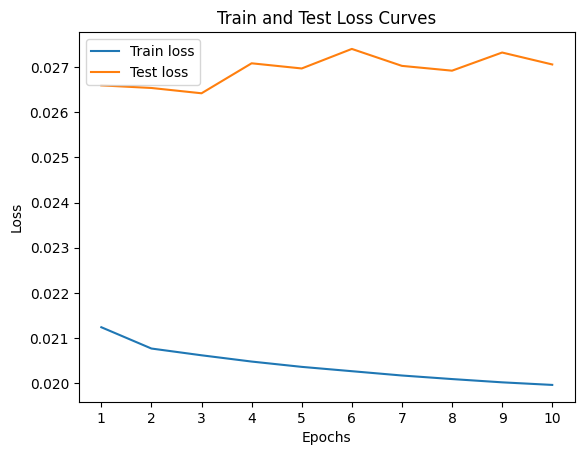

In [9]:
import matplotlib.pyplot as plt

# Plot train and test loss values
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Train and Test Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Set x-ticks to show integers only
plt.xticks(ticks=epoch_count)

plt.show()


#### Output prediction

In [36]:
# Instantiate the model and move it to the GPU (if available)
input_size = 11  # Input shape (11 features)
output_size = 22  # Output shape (22 features)


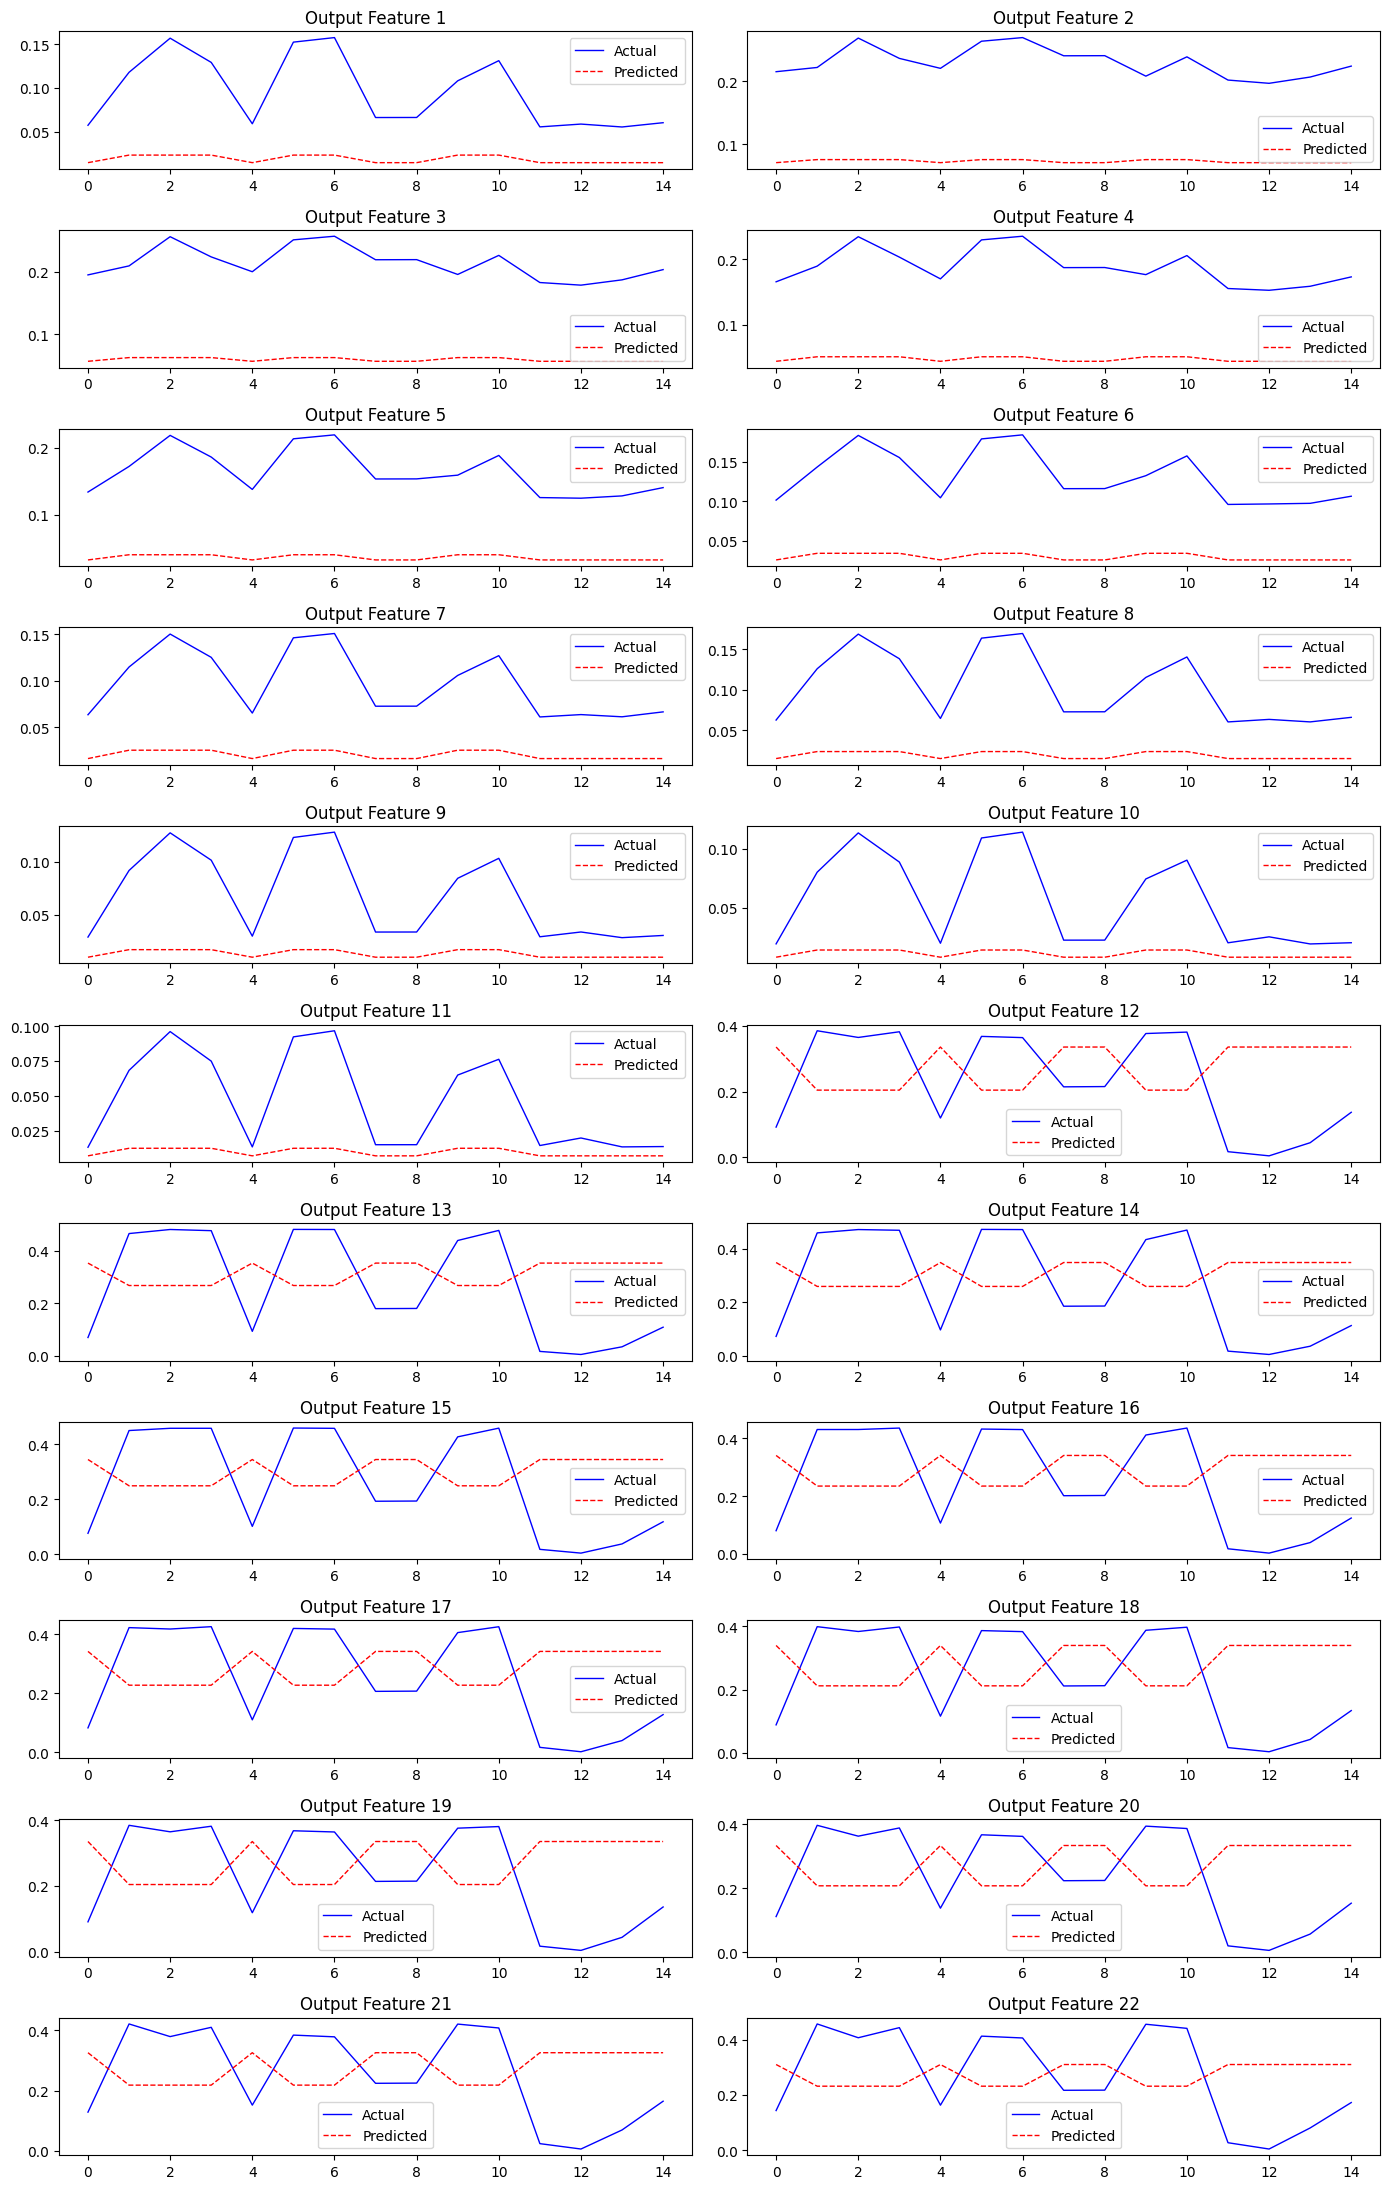

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Sample size for visualization
sample_size = 15

# Collect sample of actual and predicted outputs
sample_actuals = []
sample_predictions = []

# Set model to evaluation mode
model_io_v1.eval()
with torch.inference_mode():  # Disable gradients for evaluation
    for inputs, targets in test_dataloader:
        # Define batch size
        batch_size = inputs.shape[0]
        
        # Determine how many samples to take from this batch
        remaining_samples = sample_size - len(sample_actuals)
        num_samples = min(remaining_samples, batch_size)
        
        # Randomly select indices within the batch
        indices = np.random.choice(batch_size, num_samples, replace=False)
        
        # Select only the subset of data and move to the device
        inputs_subset = inputs[indices].to(device)
        targets_subset = targets[indices].to(device)
        
        # Make predictions
        predictions = model_io_v1(inputs_subset)
        
        # Collect predictions and actuals to CPU
        sample_actuals.append(targets_subset.cpu())
        sample_predictions.append(predictions.cpu())
        
        # Stop if we've collected enough samples
        if len(sample_actuals) >= sample_size:
            break

# Concatenate samples and convert to numpy arrays for plotting
sample_actuals = torch.cat(sample_actuals, dim=0).numpy()
sample_predictions = torch.cat(sample_predictions, dim=0).numpy()

# Plot actual vs predicted output for each feature in the output vector
num_outputs = output_size  # This is 22 as per your data shape
fig, axes = plt.subplots(num_outputs // 2, 2, figsize=(14, 2 * (num_outputs // 2)))
axes = axes.flatten()

# Adjust the x-axis range to match the sample size
x_range = range(sample_size)  # Should be 0 to 4 for a sample size of 5

for i in range(num_outputs):
    # Plot the actual and predicted values for the sample on the correct x-axis range
    axes[i].plot(x_range, sample_actuals[:sample_size, i], label='Actual', color='blue', linewidth=1)
    axes[i].plot(x_range, sample_predictions[:sample_size, i], label='Predicted', color='red', linestyle='dashed', linewidth=1)
    axes[i].set_title(f'Output Feature {i+1}')
    axes[i].legend()

plt.tight_layout()
plt.show()


## Pace318: input and geometry

### Model v2

In [43]:
# Check if a GPU is available, otherwise fall back to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the combined regression model
class CombinedRegressionModel(nn.Module):
    def __init__(self, geometry_size, input_size, output_size):
        super(CombinedRegressionModel, self).__init__()
        self.fc1 = nn.Linear(geometry_size + input_size, 64)
        # self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(64, output_size)
    
    def forward(self, geometry, input_data):
        # Concatenate geometry and input tensors along the last dimension
        x = torch.cat((geometry, input_data), dim=-1)
        x = torch.relu(self.fc1(x))
        # x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


### Training Loop

In [44]:

# Instantiate the model and move it to the GPU (if available)
geometry_size = 3  # Geometry shape (3 features)
input_size = 11  # Input shape (11 features)
output_size = 22  # Output shape (22 features)
model_gio_v2 = CombinedRegressionModel(geometry_size, input_size, output_size).to(device)


# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model_gio_v2.parameters(), lr=0.001)  # Adam optimizer

# Training loop
num_epochs = 15  # Number of training epochs

epoch_count = []
train_loss_values = []
test_loss_values = []


In [ ]:
for epoch in range(num_epochs):
    model_gio_v2.train()  # Set model to training mode
    train_loss = 0.0  # Track the total loss for this epoch

    for geometry, inputs, targets in train_dataloader:
        # Move inputs, geometry, and targets to the GPU (if available)
        geometry, inputs, targets = geometry.to(device), inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass: compute the model output
        outputs = model_gio_v2(geometry, inputs)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward pass: compute the gradients
        loss.backward()

        # Update the weights
        optimizer.step()

        # Accumulate the training loss
        train_loss += loss.item()

    # Calculate average training loss for this epoch
    avg_train_loss = train_loss / len(train_dataloader)
    train_loss_values.append(avg_train_loss)

    # Evaluate on the test set
    model_gio_v2.eval()  # Set model to evaluation mode
    test_loss = 0.0  # Track total test loss for this epoch

    with torch.inference_mode():  # No gradients needed
        for geometry, inputs, targets in test_dataloader:
            geometry, inputs, targets = geometry.to(device), inputs.to(device), targets.to(device)
            outputs = model_gio_v2(geometry, inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

    # Calculate average test loss for this epoch
    avg_test_loss = test_loss / len(test_dataloader)
    test_loss_values.append(avg_test_loss)

    # Store the epoch number
    epoch_count.append(epoch + 1)

    # Print the average losses for this epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

# Save the trained model
# torch.save(model.state_dict(), 'combined_regression_model.pth')

print("Training complete and model saved.")


Epoch [1/15], Train Loss: 0.0026, Test Loss: 0.0080
Epoch [2/15], Train Loss: 0.0007, Test Loss: 0.0079
Epoch [3/15], Train Loss: 0.0005, Test Loss: 0.0073
Epoch [4/15], Train Loss: 0.0005, Test Loss: 0.0076
Epoch [5/15], Train Loss: 0.0004, Test Loss: 0.0072
Epoch [6/15], Train Loss: 0.0004, Test Loss: 0.0073
Epoch [7/15], Train Loss: 0.0004, Test Loss: 0.0073
Epoch [8/15], Train Loss: 0.0004, Test Loss: 0.0074
Epoch [9/15], Train Loss: 0.0004, Test Loss: 0.0072
Epoch [10/15], Train Loss: 0.0004, Test Loss: 0.0074
Epoch [11/15], Train Loss: 0.0003, Test Loss: 0.0071
Epoch [12/15], Train Loss: 0.0003, Test Loss: 0.0071
Epoch [13/15], Train Loss: 0.0003, Test Loss: 0.0073
Epoch [14/15], Train Loss: 0.0003, Test Loss: 0.0072
Epoch [15/15], Train Loss: 0.0003, Test Loss: 0.0072
Training complete and model saved.


### Evaluation

#### Train and Test Loss

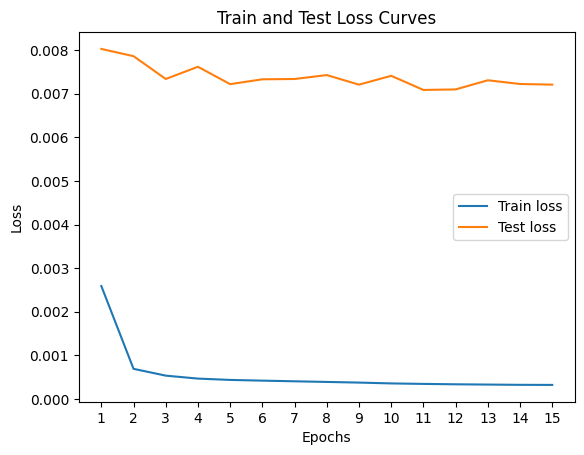

In [ ]:
import matplotlib.pyplot as plt

# Plot train and test loss values
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Train and Test Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Set x-ticks to show integers only
plt.xticks(ticks=epoch_count)

plt.show()


#### Output Prediction

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample size for visualization
sample_size = 15

# Collect sample of actual and predicted outputs
sample_actuals = []
sample_predictions = []

# Set model to evaluation mode
model_gio_v1.eval()
with torch.inference_mode():  # Disable gradients for evaluation
    for geometry, inputs, targets in test_dataloader:
        # Define batch size
        batch_size = geometry.shape[0]
        
        # Determine how many samples to take from this batch
        remaining_samples = sample_size - len(sample_actuals)
        num_samples = min(remaining_samples, batch_size)
        
        # Randomly select indices within the batch
        indices = np.random.choice(batch_size, num_samples, replace=False)
        
        # Select only the subset of data and move to the device
        geometry_subset = geometry[indices].to(device)
        inputs_subset = inputs[indices].to(device)
        targets_subset = targets[indices].to(device)
        
        # Make predictions
        predictions = model_gio_v1(geometry_subset, inputs_subset)
        
        # Collect predictions and actuals to CPU
        sample_actuals.append(targets_subset.cpu())
        sample_predictions.append(predictions.cpu())
        
        # Stop if we've collected enough samples
        if len(sample_actuals) >= sample_size:
            break

# Concatenate samples and convert to numpy arrays for plotting
sample_actuals = torch.cat(sample_actuals, dim=0).numpy()
sample_predictions = torch.cat(sample_predictions, dim=0).numpy()

# Plot actual vs predicted output for each feature in the output vector
num_outputs = output_size  # This is 22 as per your data shape
fig, axes = plt.subplots(num_outputs // 2, 2, figsize=(14, 2 * (num_outputs // 2)))
axes = axes.flatten()

# Adjust the x-axis range to match the sample size
x_range = range(sample_size)  # Should be 0 to 4 for a sample size of 5

for i in range(num_outputs):
    # Plot the actual and predicted values for the sample on the correct x-axis range
    axes[i].plot(x_range, sample_actuals[:sample_size, i], label='Actual', color='blue', linewidth=1)
    axes[i].plot(x_range, sample_predictions[:sample_size, i], label='Predicted', color='red', linestyle='dashed', linewidth=1)
    axes[i].set_title(f'Output Feature {i+1}')
    axes[i].legend()

plt.tight_layout()
plt.show()


## Model with Conv layers

In [ ]:
import torch
import torch.nn as nn

class CombinedRegressionModelWithConv(nn.Module):
    def __init__(self, geometry_size, input_size, output_size):
        super(CombinedRegressionModelWithConv, self).__init__()
        
        # Convolutional layers for feature extraction
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        
        # Fully connected layers after flattening
        self.fc1 = nn.Linear((geometry_size + input_size) * 16, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, output_size)
    
    def forward(self, geometry, input_data):
        # Concatenate geometry and input tensors along the last dimension
        x = torch.cat((geometry, input_data), dim=-1)
        
        # Reshape to add a channel dimension for 1D convolution: (batch_size, 1, total_size)
        x = x.unsqueeze(1)  # Shape: (batch_size, 1, geometry_size + input_size)
        
        # Apply convolutional layers with ReLU activation and pooling
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        
        # Flatten the output from convolutional layers
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x


In [ ]:

# Instantiate the model and move it to the GPU (if available)
geometry_size = 3  # Geometry shape (3 features)
input_size = 11  # Input shape (11 features)
output_size = 22  # Output shape (22 features)
pace318_conv_model = CombinedRegressionModelWithConv(geometry_size, input_size, output_size).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(pace318_conv_model.parameters(), lr=0.001)  # Adam optimizer

# Training loop
num_epochs = 1  # Number of training epochs

epoch_count = []
train_loss_values = []
test_loss_values = []


In [ ]:

for epoch in range(num_epochs):
    pace318_conv_model.train()  # Set model to training mode
    train_loss = 0.0  # Track the total loss for this epoch

    for geometry, inputs, targets in train_dataloader:
        # Move inputs, geometry, and targets to the GPU (if available)
        geometry, inputs, targets = geometry.to(device), inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass: compute the model output
        outputs = pace318_conv_model(geometry, inputs)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward pass: compute the gradients
        loss.backward()

        # Update the weights
        optimizer.step()

        # Accumulate the training loss
        train_loss += loss.item()

    # Calculate average training loss for this epoch
    avg_train_loss = train_loss / len(train_dataloader)
    train_loss_values.append(avg_train_loss)

    # Evaluate on the test set
    pace318_conv_model.eval()  # Set model to evaluation mode
    test_loss = 0.0  # Track total test loss for this epoch

    with torch.inference_mode():  # No gradients needed
        for geometry, inputs, targets in test_dataloader:
            geometry, inputs, targets = geometry.to(device), inputs.to(device), targets.to(device)
            outputs = pace318_conv_model(geometry, inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

    # Calculate average test loss for this epoch
    avg_test_loss = test_loss / len(test_dataloader)
    test_loss_values.append(avg_test_loss)

    # Store the epoch number
    epoch_count.append(epoch + 1)

    # Print the average losses for this epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

# Save the trained model
# torch.save(model.state_dict(), 'combined_regression_model.pth')

print("Training complete and model saved.")


Epoch [1/1], Train Loss: 0.0015, Test Loss: 0.0075
Training complete and model saved.


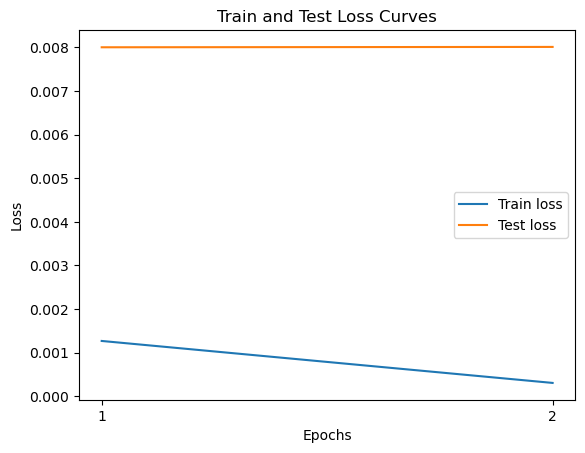

In [ ]:
import matplotlib.pyplot as plt

# Plot train and test loss values
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Train and Test Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Set x-ticks to show integers only
plt.xticks(ticks=epoch_count)

plt.show()


## Transformer model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class TransformerModel(nn.Module):
    def __init__(self, geometry_size, input_size, output_size, n_heads=2, hidden_dim=128):
        super(TransformerModel, self).__init__()
        
        self.concat_dim = geometry_size + input_size
        
        # Ensure concatenated dimension is divisible by n_heads
        assert self.concat_dim % n_heads == 0, "Concat dimension must be divisible by num_heads"
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=self.concat_dim, nhead=n_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        
        self.fc1 = nn.Linear(self.concat_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_size)
    
    def forward(self, geometry, input_data):
        x = torch.cat((geometry, input_data), dim=-1).unsqueeze(1)  # Add sequence dimension
        x = self.transformer(x).squeeze(1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [ ]:

# Instantiate the model and move it to the GPU (if available)
geometry_size = 3  # Geometry shape (3 features)
input_size = 11    # Input shape (11 features)
output_size = 22   # Output shape (22 features)
transformer_model = TransformerModel(geometry_size, input_size, output_size, n_heads=2).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(transformer_model.parameters(), lr=0.001)  # Adam optimizer


epoch_count = []
train_loss_values = []
test_loss_values = []


/home/sunzid/anaconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
model

CombinedRegressionModel(
  (fc1): Linear(in_features=14, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=22, bias=True)
)

In [ ]:

for epoch in range(num_epochs):
    transformer_model.train()  # Set model to training mode
    train_loss = 0.0  # Track the total loss for this epoch

    for geometry, inputs, targets in train_dataloader:
        # Move inputs, geometry, and targets to the GPU (if available)
        geometry, inputs, targets = geometry.to(device), inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass: compute the model output
        outputs = transformer_model(geometry, inputs)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward pass: compute the gradients
        loss.backward()

        # Update the weights
        optimizer.step()

        # Accumulate the training loss
        train_loss += loss.item()

    # Calculate average training loss for this epoch
    avg_train_loss = train_loss / len(train_dataloader)
    train_loss_values.append(avg_train_loss)

    # Evaluate on the test set
    transformer_model.eval()  # Set model to evaluation mode
    test_loss = 0.0  # Track total test loss for this epoch

    with torch.inference_mode():  # No gradients needed
        for geometry, inputs, targets in test_dataloader:
            geometry, inputs, targets = geometry.to(device), inputs.to(device), targets.to(device)
            outputs = transformer_model(geometry, inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

    # Calculate average test loss for this epoch
    avg_test_loss = test_loss / len(test_dataloader)
    test_loss_values.append(avg_test_loss)

    # Store the epoch number
    epoch_count.append(epoch + 1)

    # Print the average losses for this epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

# Save the trained model
# torch.save(model.state_dict(), 'combined_regression_model.pth')

print("Training complete and model saved.")


Epoch [1/1], Train Loss: 0.0036, Test Loss: 0.0115
Training complete and model saved.


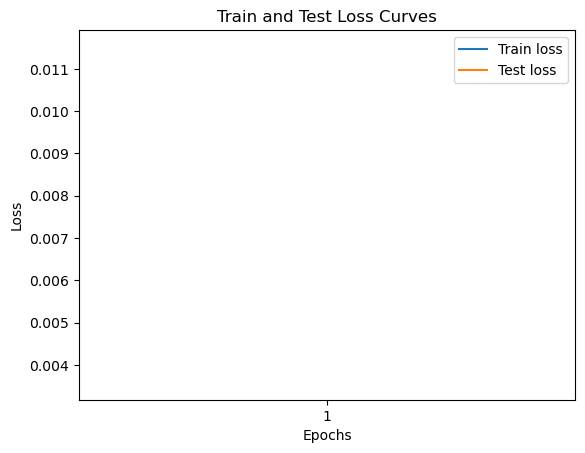

In [ ]:
import matplotlib.pyplot as plt

# Plot train and test loss values
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Train and Test Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Set x-ticks to show integers only
plt.xticks(ticks=epoch_count)

plt.show()


## Testing performance

### Show performance graphically

In [ ]:
# Instantiate the model and move it to the GPU (if available)
geometry_size = 3  # Geometry shape (3 features)
input_size = 11  # Input shape (11 features)
output_size = 22  # Output shape (22 features)

## Pace318: input and geometry

In [16]:
# Check if a GPU is available, otherwise fall back to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the combined regression model
class CombinedRegressionModel(nn.Module):
    def __init__(self, geometry_size, input_size, output_size):
        super(CombinedRegressionModel, self).__init__()
        self.fc1 = nn.Linear(geometry_size + input_size, 64)
        # self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(64, output_size)
    
    def forward(self, geometry, input_data):
        # Concatenate geometry and input tensors along the last dimension
        x = torch.cat((geometry, input_data), dim=-1)
        x = torch.relu(self.fc1(x))
        # x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [17]:

# Instantiate the model and move it to the GPU (if available)
geometry_size = 3  # Geometry shape (3 features)
input_size = 11  # Input shape (11 features)
output_size = 22  # Output shape (22 features)
model = CombinedRegressionModel(geometry_size, input_size, output_size).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Training loop
num_epochs = 15  # Number of training epochs

epoch_count = []
train_loss_values = []
test_loss_values = []


In [18]:
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0.0  # Track the total loss for this epoch

    for geometry, inputs, targets in train_dataloader:
        # Move inputs, geometry, and targets to the GPU (if available)
        geometry, inputs, targets = geometry.to(device), inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass: compute the model output
        outputs = model(geometry, inputs)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward pass: compute the gradients
        loss.backward()

        # Update the weights
        optimizer.step()

        # Accumulate the training loss
        train_loss += loss.item()

    # Calculate average training loss for this epoch
    avg_train_loss = train_loss / len(train_dataloader)
    train_loss_values.append(avg_train_loss)

    # Evaluate on the test set
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0  # Track total test loss for this epoch

    with torch.inference_mode():  # No gradients needed
        for geometry, inputs, targets in test_dataloader:
            geometry, inputs, targets = geometry.to(device), inputs.to(device), targets.to(device)
            outputs = model(geometry, inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

    # Calculate average test loss for this epoch
    avg_test_loss = test_loss / len(test_dataloader)
    test_loss_values.append(avg_test_loss)

    # Store the epoch number
    epoch_count.append(epoch + 1)

    # Print the average losses for this epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

# Save the trained model
# torch.save(model.state_dict(), 'combined_regression_model.pth')

print("Training complete and model saved.")


Epoch [1/15], Train Loss: 0.0026, Test Loss: 0.0080
Epoch [2/15], Train Loss: 0.0007, Test Loss: 0.0079
Epoch [3/15], Train Loss: 0.0005, Test Loss: 0.0073
Epoch [4/15], Train Loss: 0.0005, Test Loss: 0.0076
Epoch [5/15], Train Loss: 0.0004, Test Loss: 0.0072
Epoch [6/15], Train Loss: 0.0004, Test Loss: 0.0073
Epoch [7/15], Train Loss: 0.0004, Test Loss: 0.0073
Epoch [8/15], Train Loss: 0.0004, Test Loss: 0.0074
Epoch [9/15], Train Loss: 0.0004, Test Loss: 0.0072
Epoch [10/15], Train Loss: 0.0004, Test Loss: 0.0074
Epoch [11/15], Train Loss: 0.0003, Test Loss: 0.0071
Epoch [12/15], Train Loss: 0.0003, Test Loss: 0.0071
Epoch [13/15], Train Loss: 0.0003, Test Loss: 0.0073
Epoch [14/15], Train Loss: 0.0003, Test Loss: 0.0072
Epoch [15/15], Train Loss: 0.0003, Test Loss: 0.0072
Training complete and model saved.


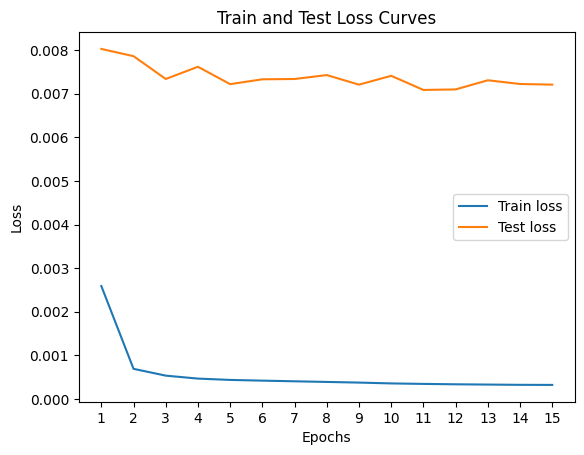

In [19]:
import matplotlib.pyplot as plt

# Plot train and test loss values
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Train and Test Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Set x-ticks to show integers only
plt.xticks(ticks=epoch_count)

plt.show()


## Model with Conv layers

In [17]:
import torch
import torch.nn as nn

class CombinedRegressionModelWithConv(nn.Module):
    def __init__(self, geometry_size, input_size, output_size):
        super(CombinedRegressionModelWithConv, self).__init__()
        
        # Convolutional layers for feature extraction
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        
        # Fully connected layers after flattening
        self.fc1 = nn.Linear((geometry_size + input_size) * 16, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, output_size)
    
    def forward(self, geometry, input_data):
        # Concatenate geometry and input tensors along the last dimension
        x = torch.cat((geometry, input_data), dim=-1)
        
        # Reshape to add a channel dimension for 1D convolution: (batch_size, 1, total_size)
        x = x.unsqueeze(1)  # Shape: (batch_size, 1, geometry_size + input_size)
        
        # Apply convolutional layers with ReLU activation and pooling
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        
        # Flatten the output from convolutional layers
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x


In [20]:

# Instantiate the model and move it to the GPU (if available)
geometry_size = 3  # Geometry shape (3 features)
input_size = 11  # Input shape (11 features)
output_size = 22  # Output shape (22 features)
pace318_conv_model = CombinedRegressionModelWithConv(geometry_size, input_size, output_size).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(pace318_conv_model.parameters(), lr=0.001)  # Adam optimizer

# Training loop
num_epochs = 1  # Number of training epochs

epoch_count = []
train_loss_values = []
test_loss_values = []


In [21]:

for epoch in range(num_epochs):
    pace318_conv_model.train()  # Set model to training mode
    train_loss = 0.0  # Track the total loss for this epoch

    for geometry, inputs, targets in train_dataloader:
        # Move inputs, geometry, and targets to the GPU (if available)
        geometry, inputs, targets = geometry.to(device), inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass: compute the model output
        outputs = pace318_conv_model(geometry, inputs)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward pass: compute the gradients
        loss.backward()

        # Update the weights
        optimizer.step()

        # Accumulate the training loss
        train_loss += loss.item()

    # Calculate average training loss for this epoch
    avg_train_loss = train_loss / len(train_dataloader)
    train_loss_values.append(avg_train_loss)

    # Evaluate on the test set
    pace318_conv_model.eval()  # Set model to evaluation mode
    test_loss = 0.0  # Track total test loss for this epoch

    with torch.inference_mode():  # No gradients needed
        for geometry, inputs, targets in test_dataloader:
            geometry, inputs, targets = geometry.to(device), inputs.to(device), targets.to(device)
            outputs = pace318_conv_model(geometry, inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

    # Calculate average test loss for this epoch
    avg_test_loss = test_loss / len(test_dataloader)
    test_loss_values.append(avg_test_loss)

    # Store the epoch number
    epoch_count.append(epoch + 1)

    # Print the average losses for this epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

# Save the trained model
# torch.save(model.state_dict(), 'combined_regression_model.pth')

print("Training complete and model saved.")


Epoch [1/1], Train Loss: 0.0015, Test Loss: 0.0075
Training complete and model saved.


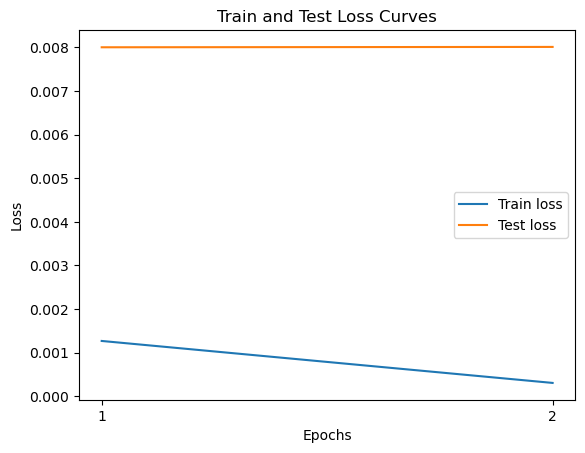

In [ ]:
import matplotlib.pyplot as plt

# Plot train and test loss values
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Train and Test Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Set x-ticks to show integers only
plt.xticks(ticks=epoch_count)

plt.show()


## Transformer model

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim

class TransformerModel(nn.Module):
    def __init__(self, geometry_size, input_size, output_size, n_heads=2, hidden_dim=128):
        super(TransformerModel, self).__init__()
        
        self.concat_dim = geometry_size + input_size
        
        # Ensure concatenated dimension is divisible by n_heads
        assert self.concat_dim % n_heads == 0, "Concat dimension must be divisible by num_heads"
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=self.concat_dim, nhead=n_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        
        self.fc1 = nn.Linear(self.concat_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_size)
    
    def forward(self, geometry, input_data):
        x = torch.cat((geometry, input_data), dim=-1).unsqueeze(1)  # Add sequence dimension
        x = self.transformer(x).squeeze(1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [27]:

# Instantiate the model and move it to the GPU (if available)
geometry_size = 3  # Geometry shape (3 features)
input_size = 11    # Input shape (11 features)
output_size = 22   # Output shape (22 features)
transformer_model = TransformerModel(geometry_size, input_size, output_size, n_heads=2).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(transformer_model.parameters(), lr=0.001)  # Adam optimizer


epoch_count = []
train_loss_values = []
test_loss_values = []


/home/sunzid/anaconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [15]:
model

CombinedRegressionModel(
  (fc1): Linear(in_features=14, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=22, bias=True)
)

In [28]:

for epoch in range(num_epochs):
    transformer_model.train()  # Set model to training mode
    train_loss = 0.0  # Track the total loss for this epoch

    for geometry, inputs, targets in train_dataloader:
        # Move inputs, geometry, and targets to the GPU (if available)
        geometry, inputs, targets = geometry.to(device), inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass: compute the model output
        outputs = transformer_model(geometry, inputs)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward pass: compute the gradients
        loss.backward()

        # Update the weights
        optimizer.step()

        # Accumulate the training loss
        train_loss += loss.item()

    # Calculate average training loss for this epoch
    avg_train_loss = train_loss / len(train_dataloader)
    train_loss_values.append(avg_train_loss)

    # Evaluate on the test set
    transformer_model.eval()  # Set model to evaluation mode
    test_loss = 0.0  # Track total test loss for this epoch

    with torch.inference_mode():  # No gradients needed
        for geometry, inputs, targets in test_dataloader:
            geometry, inputs, targets = geometry.to(device), inputs.to(device), targets.to(device)
            outputs = transformer_model(geometry, inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

    # Calculate average test loss for this epoch
    avg_test_loss = test_loss / len(test_dataloader)
    test_loss_values.append(avg_test_loss)

    # Store the epoch number
    epoch_count.append(epoch + 1)

    # Print the average losses for this epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

# Save the trained model
# torch.save(model.state_dict(), 'combined_regression_model.pth')

print("Training complete and model saved.")


Epoch [1/1], Train Loss: 0.0036, Test Loss: 0.0115
Training complete and model saved.


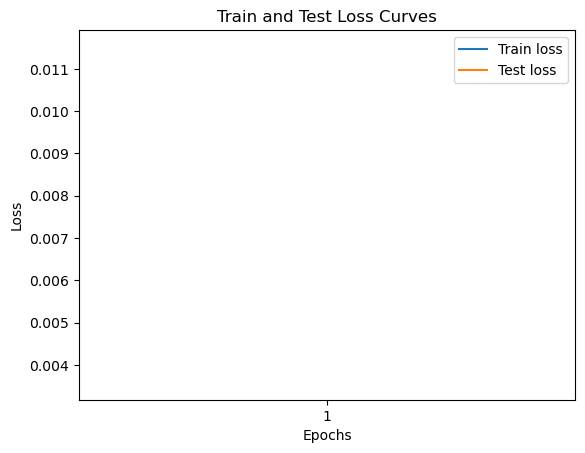

In [29]:
import matplotlib.pyplot as plt

# Plot train and test loss values
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Train and Test Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Set x-ticks to show integers only
plt.xticks(ticks=epoch_count)

plt.show()


## Testing performance

### Show performance graphically

In [ ]:
# Instantiate the model and move it to the GPU (if available)
geometry_size = 3  # Geometry shape (3 features)
input_size = 11  # Input shape (11 features)
output_size = 22  # Output shape (22 features)
model = CombinedRegressionModel(geometry_size, input_size, output_size).to(device)

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Sample size for visualization
sample_size = 15

# Collect sample of actual and predicted outputs
sample_actuals = []
sample_predictions = []

# Set model to evaluation mode
model.eval()
with torch.inference_mode():  # Disable gradients for evaluation
    for geometry, inputs, targets in test_dataloader:
        # Define batch size
        batch_size = geometry.shape[0]
        
        # Determine how many samples to take from this batch
        remaining_samples = sample_size - len(sample_actuals)
        num_samples = min(remaining_samples, batch_size)
        
        # Randomly select indices within the batch
        indices = np.random.choice(batch_size, num_samples, replace=False)
        
        # Select only the subset of data and move to the device
        geometry_subset = geometry[indices].to(device)
        inputs_subset = inputs[indices].to(device)
        targets_subset = targets[indices].to(device)
        
        # Make predictions
        predictions = model(geometry_subset, inputs_subset)
        
        # Collect predictions and actuals to CPU
        sample_actuals.append(targets_subset.cpu())
        sample_predictions.append(predictions.cpu())
        
        # Stop if we've collected enough samples
        if len(sample_actuals) >= sample_size:
            break

# Concatenate samples and convert to numpy arrays for plotting
sample_actuals = torch.cat(sample_actuals, dim=0).numpy()
sample_predictions = torch.cat(sample_predictions, dim=0).numpy()

# Plot actual vs predicted output for each feature in the output vector
num_outputs = output_size  # This is 22 as per your data shape
fig, axes = plt.subplots(num_outputs // 2, 2, figsize=(14, 2 * (num_outputs // 2)))
axes = axes.flatten()

# Adjust the x-axis range to match the sample size
x_range = range(sample_size)  # Should be 0 to 4 for a sample size of 5

for i in range(num_outputs):
    # Plot the actual and predicted values for the sample on the correct x-axis range
    axes[i].plot(x_range, sample_actuals[:sample_size, i], label='Actual', color='blue', linewidth=1)
    axes[i].plot(x_range, sample_predictions[:sample_size, i], label='Predicted', color='red', linestyle='dashed', linewidth=1)
    axes[i].set_title(f'Output Feature {i+1}')
    axes[i].legend()

plt.tight_layout()
plt.show()


ValueError: not enough values to unpack (expected 3, got 2)

1. Line Plot for Each Feature
Plotting each of the 22 features with separate line plots lets you clearly compare the predicted and actual values for each feature across samples.

In [30]:
import matplotlib.pyplot as plt

def plot_output_comparison(y_true, y_pred, sample_idx=0):
    plt.figure(figsize=(15, 10))
    for i in range(22):
        plt.subplot(5, 5, i + 1)
        plt.plot(y_true[:, i], label='Actual', color='blue')
        plt.plot(y_pred[:, i], label='Predicted', color='red', linestyle='--')
        plt.title(f'Output {i+1}')
        plt.legend()
    plt.tight_layout()
    plt.show()


2. Scatter Plot of Actual vs. Predicted for Each Feature
A scatter plot for each output feature can show the relationship between actual and predicted values. Ideally, points should fall along the 45-degree line if predictions are accurate.

In [ ]:
import numpy as np

def scatter_plot_comparison(y_true, y_pred):
    plt.figure(figsize=(15, 10))
    for i in range(22):
        plt.subplot(5, 5, i + 1)
        plt.scatter(y_true[:, i], y_pred[:, i], alpha=0.5)
        plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title(f'Output {i+1}')
    plt.tight_layout()
    plt.show()


3. Bar Plot of Error for Each Output Feature
Calculate the mean absolute error for each output feature across all samples, then plot as a bar chart to compare errors per feature.

In [ ]:
import numpy as np

def plot_error_bar(y_true, y_pred):
    errors = np.abs(y_true - y_pred).mean(axis=0)  # Mean absolute error for each output feature
    plt.figure(figsize=(10, 5))
    plt.bar(range(1, 23), errors, color='orange')
    plt.xlabel('Output Feature')
    plt.ylabel('Mean Absolute Error')
    plt.title('Mean Absolute Error per Output Feature')
    plt.show()


4. Overlayed Line Plot of Sample Predictions
Plot predictions and actual values for all features of a single sample, with each feature represented by a different line in the same plot.

In [ ]:
def plot_single_sample_comparison(y_true, y_pred, sample_idx=0):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true[sample_idx], label="Actual", marker='o', color='blue')
    plt.plot(y_pred[sample_idx], label="Predicted", marker='x', color='red')
    plt.xlabel('Output Feature')
    plt.ylabel('Value')
    plt.title(f'Comparison for Sample {sample_idx + 1}')
    plt.legend()
    plt.show()


5. Heatmap of Prediction Errors
Display a heatmap showing errors across multiple samples for all features, with each row representing a sample and each column representing an output feature.

In [ ]:
import seaborn as sns

def plot_error_heatmap(y_true, y_pred):
    errors = np.abs(y_true - y_pred)  # Calculate absolute error
    plt.figure(figsize=(12, 8))
    sns.heatmap(errors, cmap="coolwarm", cbar=True)
    plt.xlabel("Output Feature")
    plt.ylabel("Sample")
    plt.title("Absolute Errors for Each Sample and Output Feature")
    plt.show()


### Performance tests


In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Convert tensors to numpy arrays if needed
sample_actuals = sample_actuals.reshape(-1, output_size)  # Shape: (sample_size, 22)
sample_predictions = sample_predictions.reshape(-1, output_size)  # Shape: (sample_size, 22)

# Calculate regression metrics
mse = mean_squared_error(sample_actuals, sample_predictions)
mae = mean_absolute_error(sample_actuals, sample_predictions)
r2 = r2_score(sample_actuals, sample_predictions)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Mean Squared Error (MSE): 0.0168
Mean Absolute Error (MAE): 0.0795
R-squared (R²): -0.3091


1. Accuracy
Definition: The ratio of correct predictions to the total number of predictions.
Use Case: Suitable when classes are balanced.

In [ ]:
from sklearn.metrics import accuracy_score

def compute_accuracy(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.2f}")


2. Confusion Matrix
Definition: A table that shows the counts of true positives, true negatives, false positives, and false negatives for each class.
Use Case: Helpful for visualizing performance across classes and identifying specific classes that the model struggles with.

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


3. Precision, Recall, and F1 Score
Precision: Measures how many positive predictions were actually correct (useful for assessing false positives).
Recall: Measures how many true positives were correctly identified (useful for assessing false negatives).
F1 Score: The harmonic mean of precision and recall, giving a balanced metric for imbalanced classes.
Use Case: Particularly helpful when class distribution is skewed, or for evaluating models in situations where false positives or false negatives have significant consequences.


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compute_classification_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")


4. ROC Curve and AUC (Area Under the Curve)
ROC Curve: Plots the true positive rate (TPR) against the false positive rate (FPR) at various classification thresholds.
AUC: Measures the area under the ROC curve, with a higher AUC indicating better model performance across thresholds.
Use Case: Useful for binary and multi-class classification, especially in situations with class imbalance.

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def plot_roc_curve(y_true, y_proba):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.plot(fpr, tpr, label="ROC Curve (AUC = %.2f)" % roc_auc_score(y_true, y_proba))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()


5. Precision-Recall Curve and Average Precision (AP)
Precision-Recall Curve: Plots precision against recall at various probability thresholds.
Average Precision (AP): Summarizes the precision-recall curve as a single score, useful in the context of imbalanced datasets.
Use Case: Particularly insightful for datasets with a high class imbalance.

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_precision_recall_curve(y_true, y_proba):
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    ap = average_precision_score(y_true, y_proba)
    plt.plot(recall, precision, label="Precision-Recall Curve (AP = %.2f)" % ap)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()


6. Log Loss (Cross-Entropy Loss)
Definition: Measures the uncertainty of predictions, penalizing both overconfident wrong predictions and underconfident right predictions.
Use Case: Useful for models that output probabilities rather than hard labels.

In [ ]:
from sklearn.metrics import log_loss

def compute_log_loss(y_true, y_proba):
    loss = log_loss(y_true, y_proba)
    print(f"Log Loss: {loss:.4f}")


7. Classification Report
Definition: Summarizes precision, recall, F1-score, and support for each class.
Use Case: A quick way to evaluate the model’s performance across classes.


In [ ]:
from sklearn.metrics import classification_report

def print_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred)
    print(report)
